In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import napari
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

C:\Users\roman\AppData\Local\Temp\ipykernel_8160\3890474644.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Read in Data

In [2]:
# Load the dataframe from the csv file
file_name = "results/pred04_240325220507.csv"
df = pd.read_csv(file_name)
df[:5]
# df.shape

,img_num,prediction type,scribbles mode,scribbles bin,suffix,class_1_pix_gt,class_2_pix_gt,pix_labelled,class_1_pix_labelled,class_2_pix_labelled,pix_in_img,perc. labelled,accuracy,image,ground truth,scribbles,prediction
0,0,convpaint_l-0_s-1,all,0.1,a,101577,94519,174,84,90,196096,0.088732,0.940106,results\data\pred05_run1/000_img.png,results\data\pred05_run1/000_ground_truth.png,results\data\pred05_run1/000_scribbles_all_001...,results\data\pred05_run1/000_convpaint_l-0_s-1...
1,0,convpaint_l-0_s-1-2,all,0.1,a,101577,94519,174,84,90,196096,0.088732,0.928479,results\data\pred05_run1/000_img.png,results\data\pred05_run1/000_ground_truth.png,results\data\pred05_run1/000_scribbles_all_001...,results\data\pred05_run1/000_convpaint_l-0_s-1...
2,0,convpaint_l-0_s-1-2-4,all,0.1,a,101577,94519,174,84,90,196096,0.088732,0.919182,results\data\pred05_run1/000_img.png,results\data\pred05_run1/000_ground_truth.png,results\data\pred05_run1/000_scribbles_all_001...,results\data\pred05_run1/000_convpaint_l-0_s-1...
3,0,convpaint_l-0_s-1-2-4-8,all,0.1,a,101577,94519,174,84,90,196096,0.088732,0.912155,results\data\pred05_run1/000_img.png,results\data\pred05_run1/000_ground_truth.png,results\data\pred05_run1/000_scribbles_all_001...,results\data\pred05_run1/000_convpaint_l-0_s-1...
4,0,convpaint_l-0-2_s-1,all,0.1,a,101577,94519,174,84,90,196096,0.088732,0.895470,results\data\pred05_run1/000_img.png,results\data\pred05_run1/000_ground_truth.png,results\data\pred05_run1/000_scribbles_all_001...,results\data\pred05_run1/000_convpaint_l-0-2_s...


## Compare convpaint to ilastik (accuracies)

In [3]:
df_2 = df.copy()

# Add ilastik accuracy on the same row as convpaint accuracy as a new column ("acc. ilastik")
for scr in df_2['scribbles']:
    acc_il = df_2.loc[(df_2['scribbles'] == scr) & (df_2['prediction type'] == "ilastik"), "accuracy"].values[0]
    df_2.loc[(df_2['scribbles'] == scr) & (df_2['prediction type'] == "convpaint"), "acc. ilastik"] = acc_il

# Rename the "accuracy" column to "acc. convpaint"
df_2.rename(columns={"accuracy": "acc. convpaint"}, inplace=True)
# Add difference between convpaint and ilastik accuracy in a new column ("acc. diff")
df_2["acc. diff"] = df_2["acc. convpaint"] - df_2["acc. ilastik"]
# Move the columns
df_2 = df_2[["img_num", "scribbles mode", "scribbles bin", "suffix", "class_1_pix_gt", "class_2_pix_gt", "pix_labelled", "class_1_pix_labelled", "class_2_pix_labelled", "pix_in_img", "perc. labelled", "acc. convpaint", "acc. ilastik", "acc. diff", "image", "ground truth", "scribbles"]]
# Remove rows with NaN values (former rows with ilastik accuracy...)
df_2 = df_2.dropna()


In [5]:
# df_2[df_2['acc. convpaint'] < 0.6].sort_values(by="acc. diff", ascending=True)['image'].shape
df_2[df_2['scribbles bin'] > 0.03].sort_values(by="acc. diff", ascending=True)[0:20]

,img_num,scribbles mode,scribbles bin,suffix,class_1_pix_gt,class_2_pix_gt,pix_labelled,class_1_pix_labelled,class_2_pix_labelled,pix_in_img,perc. labelled,acc. convpaint,acc. ilastik,acc. diff,image,ground truth,scribbles
5578,398,all,0.10,a,34337,42463,71,30,41,76800,0.092448,0.421315,0.737435,-0.316120,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
3184,227,all,0.10,a,55432,102264,143,52,91,157696,0.090681,0.638488,0.915451,-0.276963,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
5576,398,all,0.05,a,34337,42463,31,15,16,76800,0.040365,0.497565,0.769440,-0.271875,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
3672,262,all,0.05,a,4222,35778,15,2,13,40000,0.037500,0.628800,0.893775,-0.264975,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
5702,407,all,0.05,a,60192,128224,84,26,58,188416,0.044582,0.637260,0.889441,-0.252181,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
3758,268,all,0.10,a,19223,31402,45,16,29,50625,0.088889,0.596642,0.839170,-0.242528,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
5522,394,all,0.10,a,89045,85035,161,83,78,174080,0.092486,0.551517,0.785334,-0.233818,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
2622,187,all,0.05,a,18651,31628,23,8,15,50279,0.045745,0.646135,0.873784,-0.227650,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
5900,421,all,0.10,a,126875,135269,250,123,127,262144,0.095367,0.517982,0.744396,-0.226414,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
3756,268,all,0.05,a,19223,31402,23,8,15,50625,0.045432,0.486380,0.692405,-0.206025,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...


In [6]:
df_3 = df_2.copy()
df_3 = df_3.sort_values(by="acc. diff", ascending=True)#[50:]

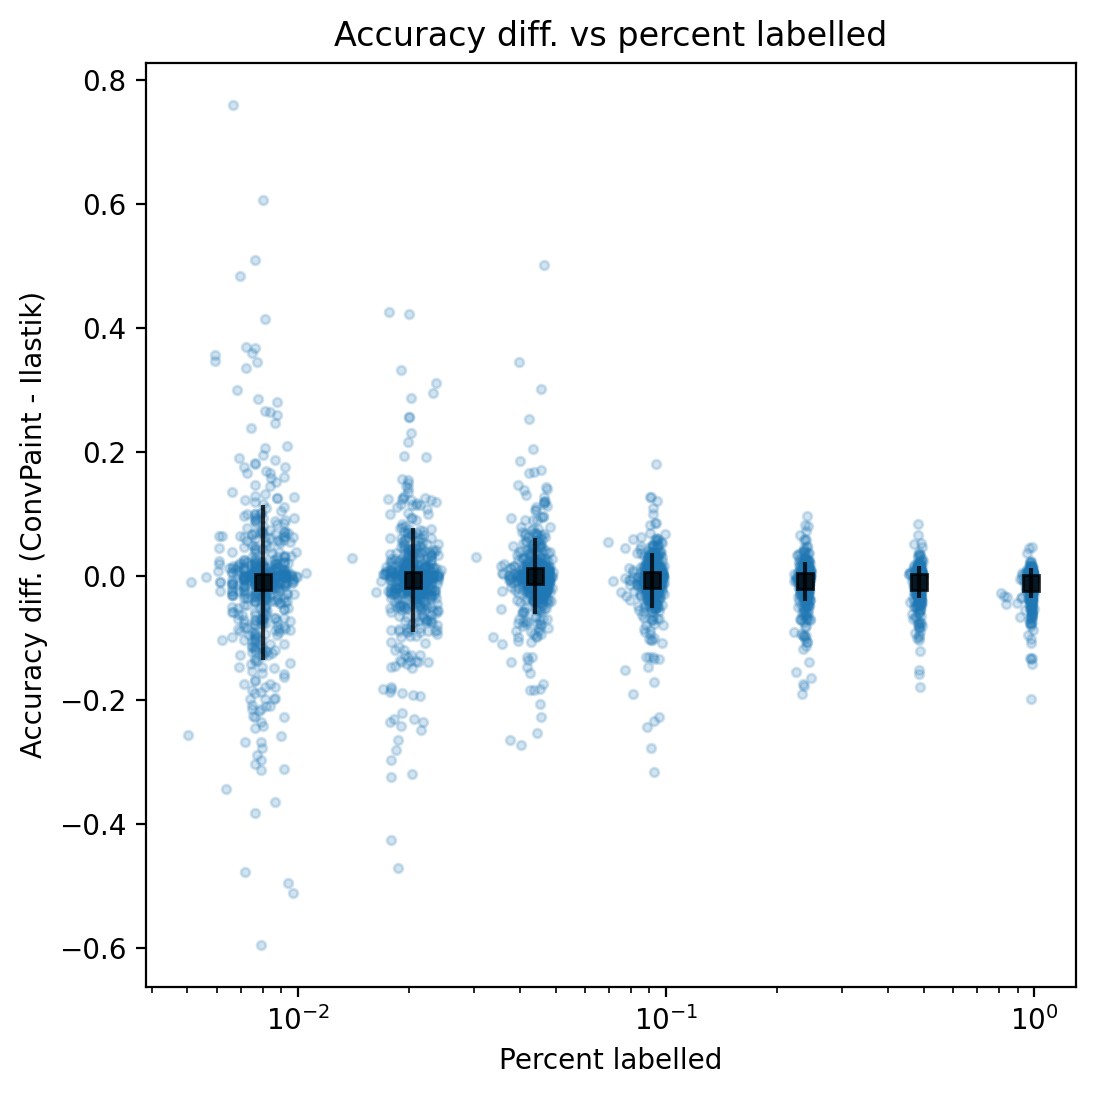

In [43]:
# Plot the data in matplotlib scatter plot
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 6)
# # set dpi
fig.set_dpi(200)

# scatter_ax = ax[0]
# sns.scatterplot(x="acc. convpaint", y="acc. ilastik", hue="scribbles bin", data=df_3, palette="viridis", s=30, alpha=0.8, ax=scatter_ax, legend=False, marker='.')
# # scatter_ax.scatter(df_3['acc. convpaint'], df_3['acc. ilastik'], c=df_3['scribbles bin'], cmap='viridis', s=20, alpha=0.7)
# scatter_ax.plot([0, 1], [0, 1], transform=scatter_ax.transAxes, c='black', alpha=0.5)
# scatter_ax.set_xlabel("Accuracy ConvPaint")
# scatter_ax.set_ylabel("Accuracy Ilastik")
# scatter_ax.set_title("Accuracy ConvPaint vs Accuracy Ilastik")

diff_ax = ax
diff_ax.scatter(df_3['perc. labelled'], df_3['acc. diff'], alpha=0.2, s=10)
df_grouped = df_3.groupby('scribbles bin').agg({'acc. diff': ['mean', 'std'], 'perc. labelled': 'mean'}).reset_index()
diff_ax.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['acc. diff']['mean'], yerr=df_grouped['acc. diff']['std'], fmt='s', c='black', alpha=0.8)
diff_ax.set_xscale('log')
diff_ax.set_xlabel('Percent labelled')
diff_ax.set_ylabel('Accuracy diff. (ConvPaint - Ilastik)')
diff_ax.set_title(f'Accuracy diff. vs percent labelled')
plt.show()

## Preprocess for plotting

In [5]:
# Filter out some bins
# df = df[df['scribbles bin'] != 0.01]
# df = df[df['scribbles bin'] != 1]
# df = df[df['class_1_pix_labelled'] >= 5]
# df = df[df['class_2_pix_labelled'] >= 5]
# Change the values of the prediction types to be more readable
# df['prediction type'] = df['prediction type'].apply(lambda x: "convpaint" if x == "convpaintCh1" else "classic filters")


# Create two filtered dataframes
df['prediction type'] = df['prediction type'].apply(lambda x: "classic filters" if x == "ilastik" else x)
df_convpaint = df[df['prediction type'] == 'convpaint']
df_ilastik = df[df['prediction type'] == 'classic filters']
df[:5]

,img_num,prediction type,scribbles mode,scribbles bin,suffix,class_1_pix_gt,class_2_pix_gt,pix_labelled,class_1_pix_labelled,class_2_pix_labelled,pix_in_img,perc. labelled,accuracy,image,ground truth,scribbles,prediction
0,0,convpaint,all,0.010,a,101577,94519,18,9,9,196096,0.009179,0.917306,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
1,0,classic filters,all,0.010,a,101577,94519,18,9,9,196096,0.009179,0.929356,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
2,0,convpaint,all,0.025,a,101577,94519,40,22,18,196096,0.020398,0.921467,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
3,0,classic filters,all,0.025,a,101577,94519,40,22,18,196096,0.020398,0.906704,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
4,0,convpaint,all,0.050,a,101577,94519,79,38,41,196096,0.040286,0.930753,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...


## Plot only one prediction type

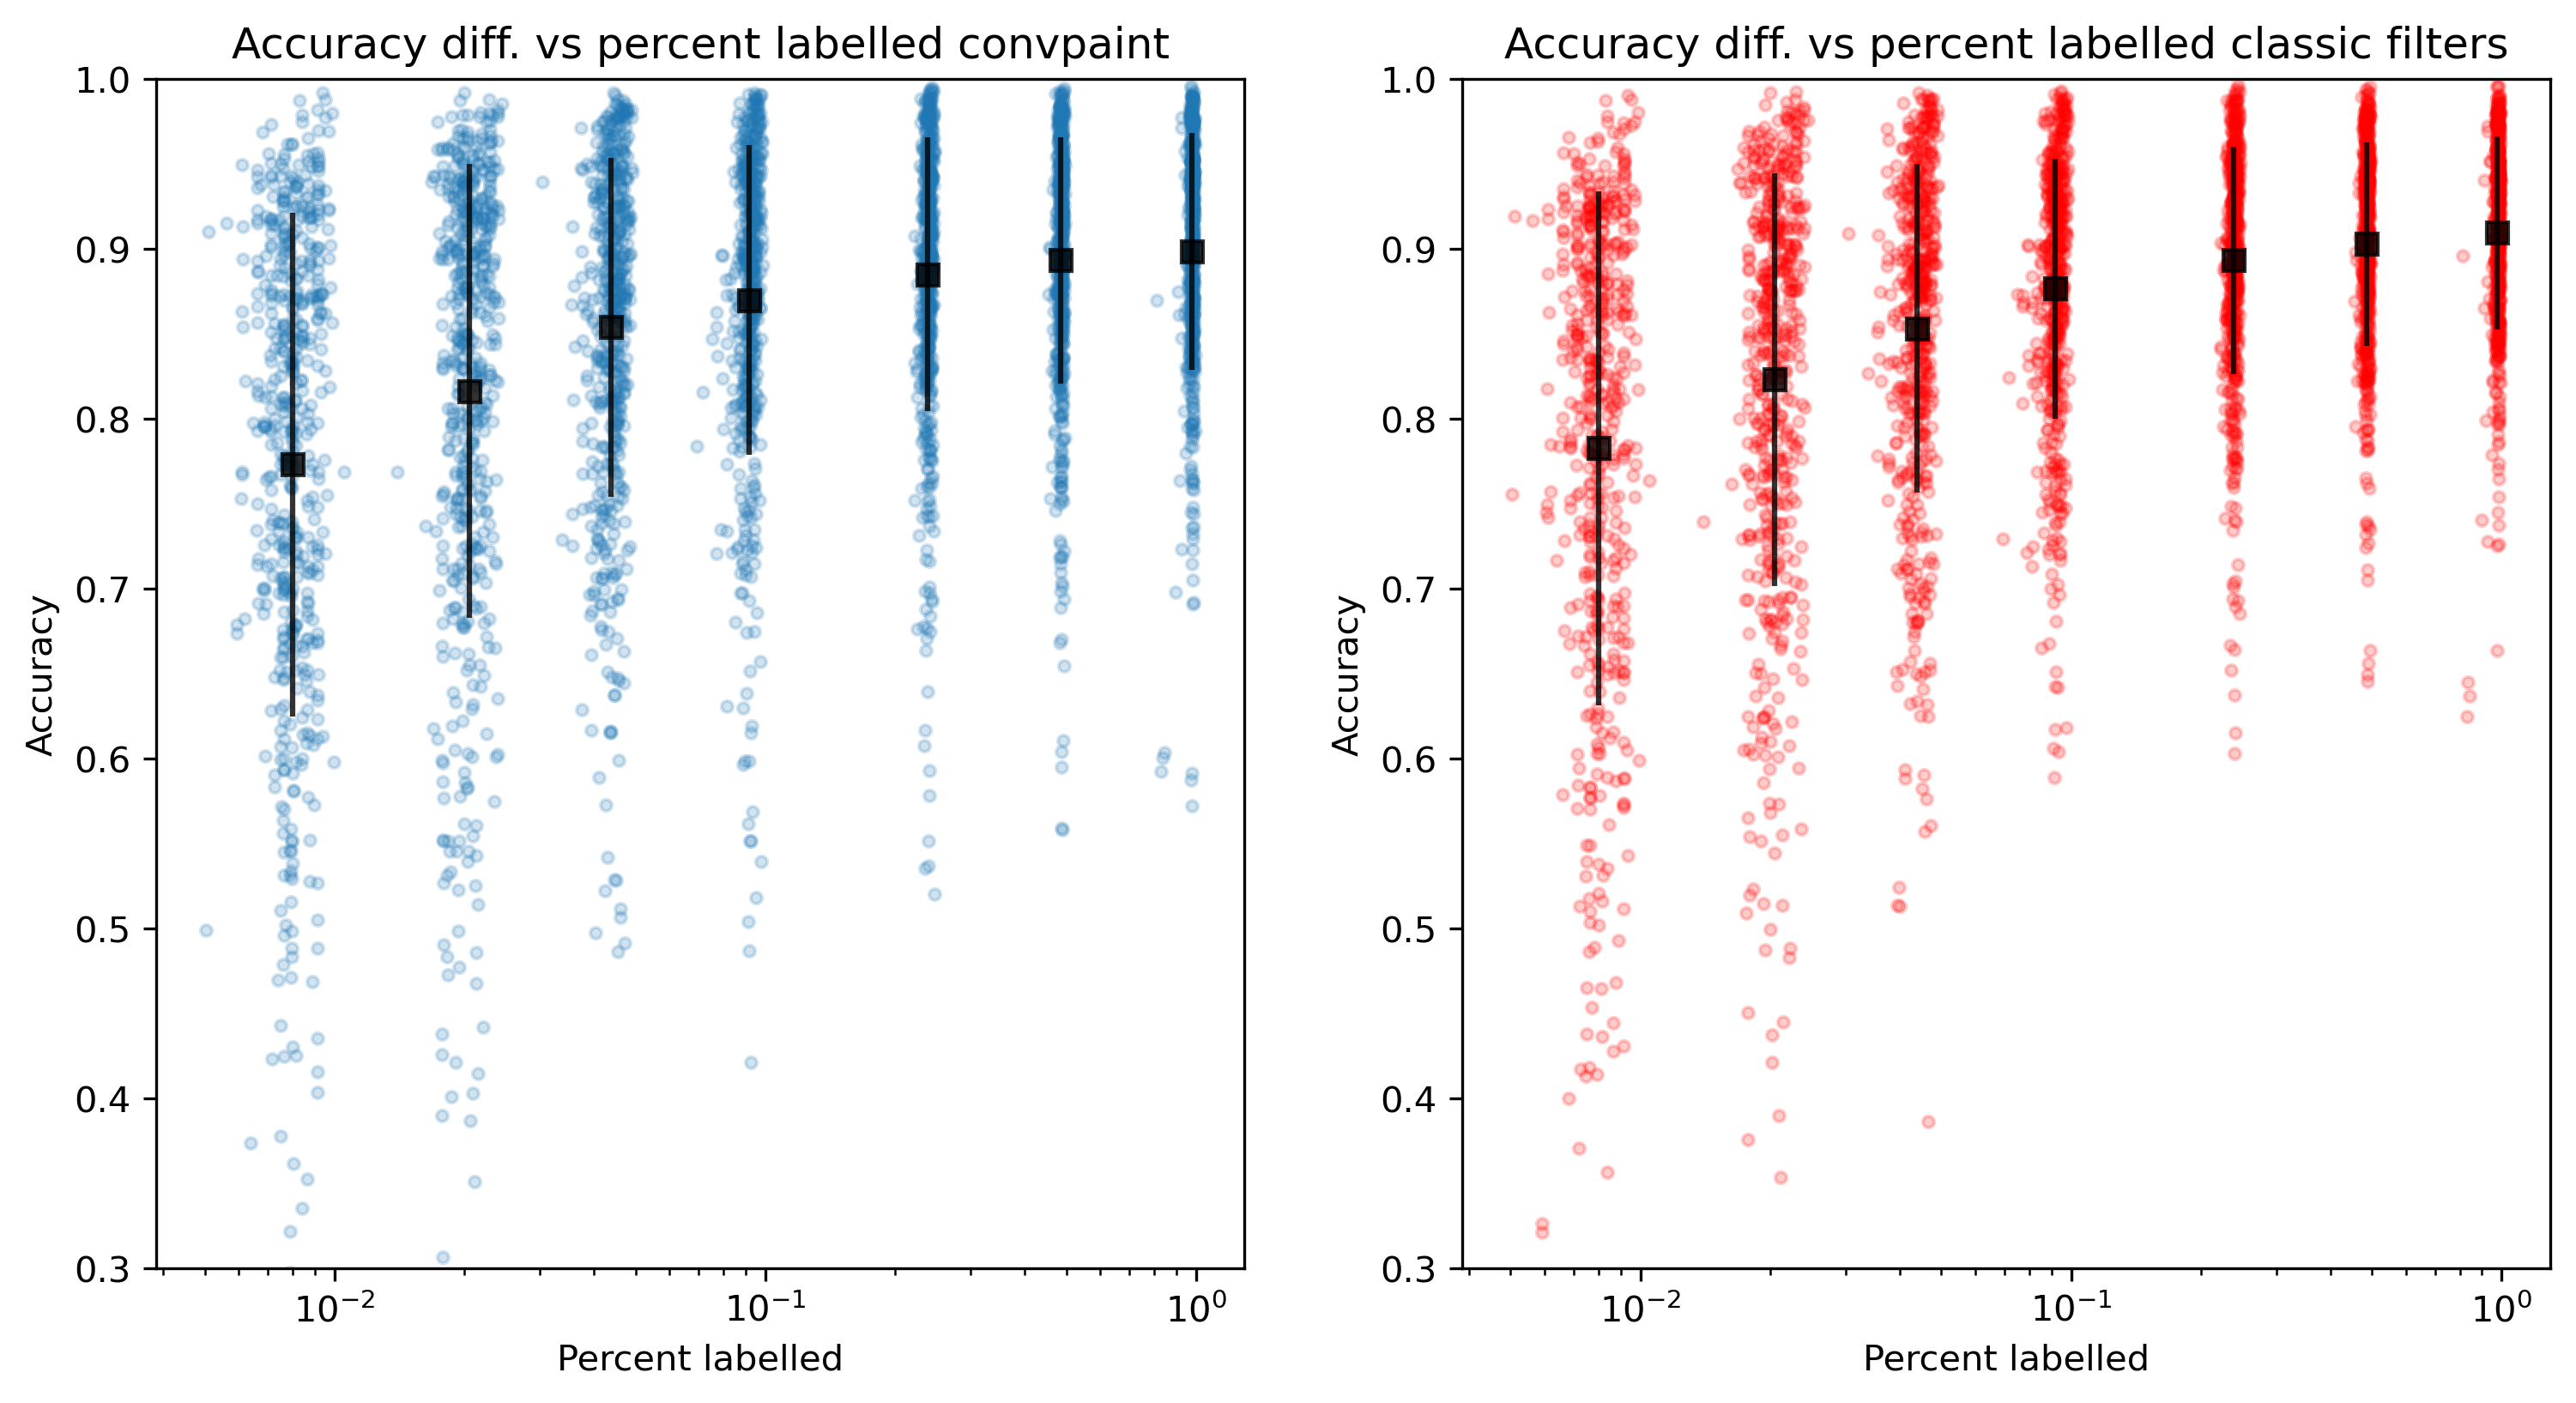

In [14]:
def plot_accuracy_vs_perc_labelled(df, pred_to_show="convpaint", plt_ax=None, **kwargs):
    if plt_ax is None:
        plt_ax = plt.subplots(1, 1)[1]
    # Plot accuracy vs percent labelled
    df_filtered = df[df['prediction type'] == pred_to_show]

    # Scatterplot
    plt_ax.scatter(df_filtered['perc. labelled'], df_filtered['accuracy'], alpha=0.2, s=10, **kwargs)

    # Grouped plot
    df_grouped = df_filtered.groupby('scribbles bin').agg({'accuracy': ['mean', 'std'], 'perc. labelled': 'mean'}).reset_index()
    plt_ax.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['mean'], yerr=df_grouped['accuracy']['std'], fmt='s', c='black', alpha=0.8)
    plt_ax.set_xscale('log')
    plt_ax.set_ylim(0.3, 1)
    # plt_ax.set_xticks([0.05, 0.1, 1])
    plt_ax.set_xlabel('Percent labelled')
    plt_ax.set_ylabel('Accuracy')
    plt_ax.set_title(f'Accuracy diff. vs percent labelled {pred_to_show}')

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
# set dpi
fig.set_dpi(300)
plot_accuracy_vs_perc_labelled(df, 'convpaint', plt_ax=ax[0])
plot_accuracy_vs_perc_labelled(df, 'classic filters', plt_ax=ax[1], c='red')
plt.show()


## Plot both prediction types together (convpaint vs. ilastik)

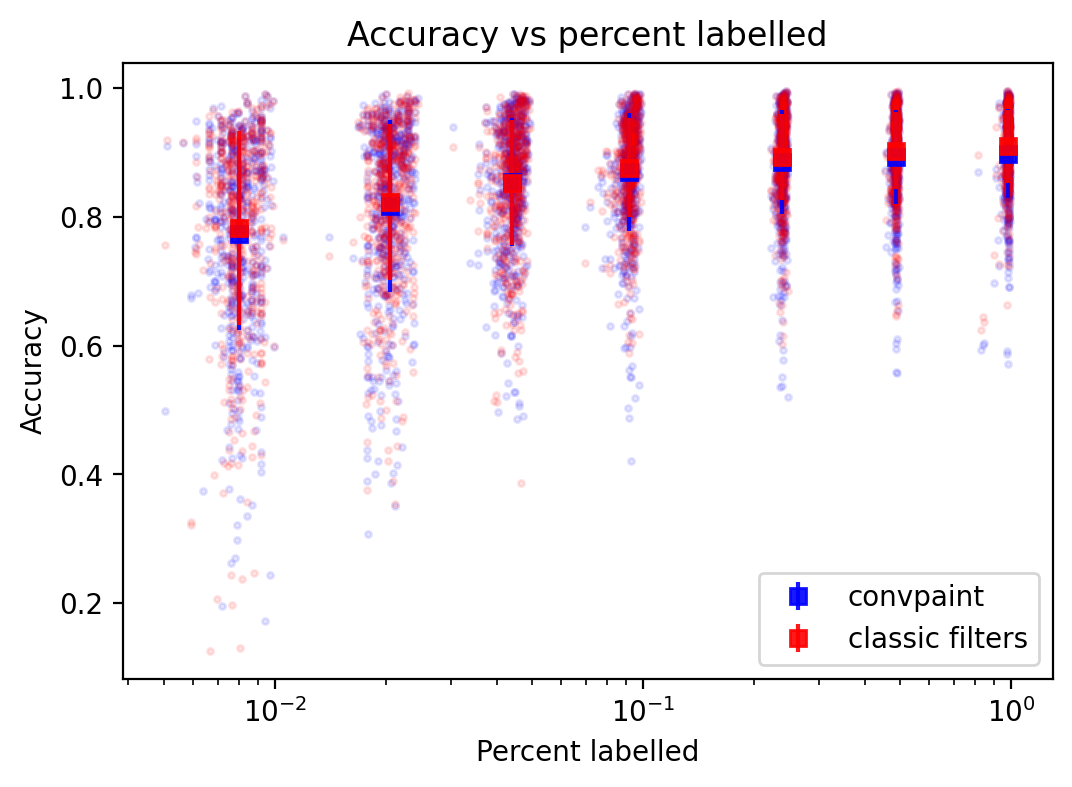

In [6]:
# Plot accuracy vs percent labelled
plt.figure(figsize=(6,4),dpi=200)

# ADD CONVPAINT PLOT
# Scatterplot
plt.scatter(df_convpaint['perc. labelled'], df_convpaint['accuracy'], alpha=0.1, s=5, c='blue')
# Grouped plot
df_grouped = df_convpaint.groupby('scribbles bin').agg({'accuracy': ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['mean'], yerr=df_grouped['accuracy']['std'], fmt='s', c='blue', alpha=0.9, label='convpaint')
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['median'], yerr=0, fmt='s', c='blue', alpha=0.9)

# ADD ILASTIK PLOT
# Scatterplot
plt.scatter(df_ilastik['perc. labelled'], df_ilastik['accuracy'], alpha=0.1, s=5, c='red')
# Grouped plot
df_grouped = df_ilastik.groupby('scribbles bin').agg({'accuracy': ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['mean'], yerr=df_grouped['accuracy']['std'], fmt='s', c='red', alpha=0.9, label='classic filters')
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['median'], yerr=0, fmt='s', c='red', alpha=0.9)

# ADJUST PARAMETERS
plt.xscale('log')
plt.xlabel('Percent labelled')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percent labelled')
plt.legend()
plt.show()

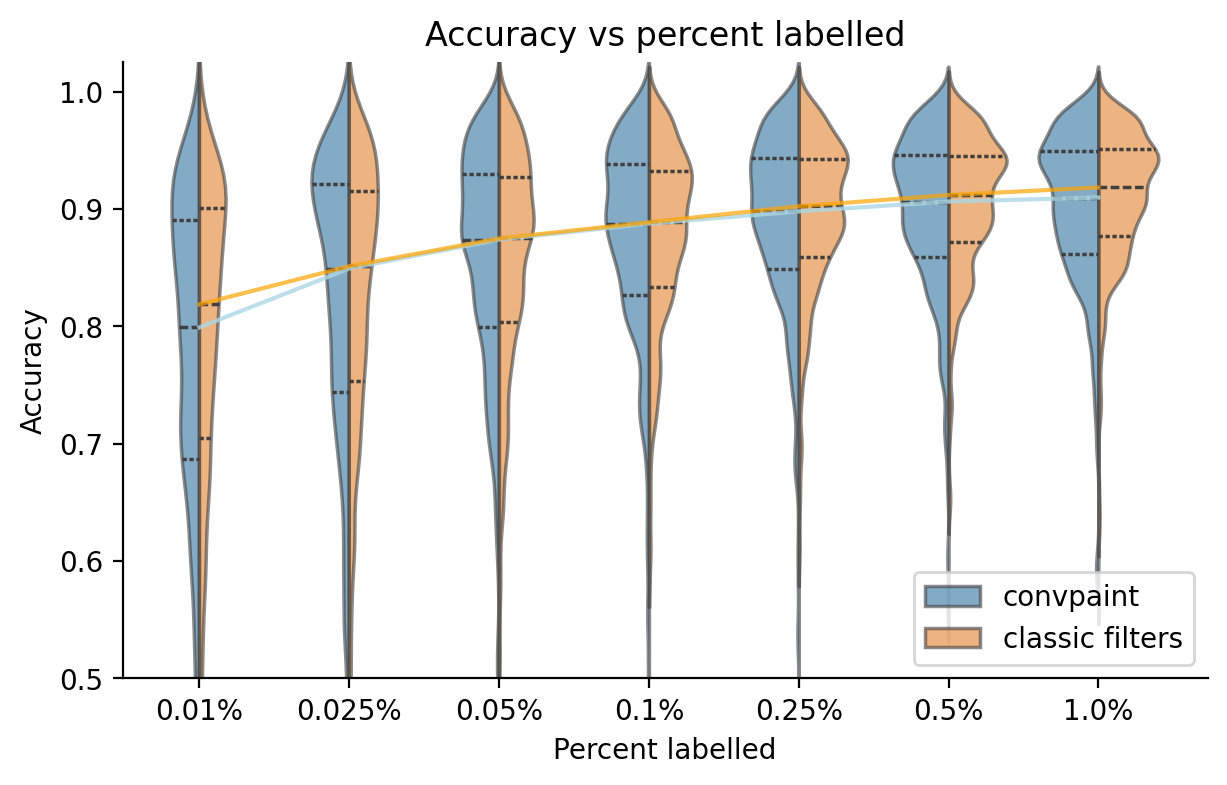

In [7]:
# Add a [0,0] point to the grouped dataframes manually
# df_convpaint_grouped = pd.concat([pd.DataFrame({'scribbles bin': [0], 'accuracy': [0]}), df_convpaint_grouped], ignore_index=True)
# df_ilastik_grouped = pd.concat([pd.DataFrame({'scribbles bin': [0], 'accuracy': [0]}), df_ilastik_grouped], ignore_index=True)
# df = df.append({'scribbles bin': 0, 'accuracy': 0, 'prediction type': 'convpaint'}, ignore_index=True)
# df = df.append({'scribbles bin': 0, 'accuracy': 0, 'prediction type': 'classic filters'}, ignore_index=True)

plt.figure(figsize=(7, 4), dpi=200)

# Plot violin plot with seaborn split the violin between convpaint and ilastik
# Create the violin plot
ax = sns.violinplot(x='scribbles bin', y='accuracy', data=df, hue='prediction type', split=True, alpha=0.6, inner="quart", bw_adjust=0.65)

# Create line plot
# Group the bins
df_convpaint_grouped = df_convpaint.groupby('scribbles bin').agg({'accuracy': 'median'}).reset_index()
df_ilastik_grouped = df_ilastik.groupby('scribbles bin').agg({'accuracy': 'median'}).reset_index()
# Plot the means of each bin and connect them with a line
x_positions = ax.get_xticks()
plt.plot(x_positions, df_convpaint_grouped['accuracy'], color='lightblue', alpha=0.8)
plt.plot(x_positions, df_ilastik_grouped['accuracy'], color='orange', alpha=0.7)

# Set some parameters
x_labels = [f"{x}%" for x in df_convpaint_grouped['scribbles bin']]
plt.ylim(0.5, 1.025)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(x_positions, x_labels)
plt.legend(loc='lower right')
plt.xlabel('Percent labelled')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percent labelled')

# Show or save the plot
plt.show()
# plt.savefig("convpaint-vs-ilastik_acc-vs-lab.svg", format='svg')

## Compare VGG16 models

In [13]:
file_name = "results/pred05_run01_240328171424.csv"
df = pd.read_csv(file_name)
# Extract layers and scalings
df['layer'] = df['prediction type'].str.extract(r'l-(\d+-?\d*)')
df['scaling'] = df['prediction type'].str.extract(r's-(\d+-?\d*-?\d*-?\d*)')
df[:5]

,img_num,prediction type,scribbles mode,scribbles bin,suffix,class_1_pix_gt,class_2_pix_gt,pix_labelled,class_1_pix_labelled,class_2_pix_labelled,pix_in_img,perc. labelled,accuracy,image,ground truth,scribbles,prediction,layer,scaling
0,0,convpaint_l-0_s-1,all,0.1,a,101577,94519,174,84,90,196096,0.088732,0.940106,results\data\pred05_run1/000_img.png,results\data\pred05_run1/000_ground_truth.png,results\data\pred05_run1/000_scribbles_all_001...,results\data\pred05_run1/000_convpaint_l-0_s-1...,0,1
1,0,convpaint_l-0_s-1-2,all,0.1,a,101577,94519,174,84,90,196096,0.088732,0.928479,results\data\pred05_run1/000_img.png,results\data\pred05_run1/000_ground_truth.png,results\data\pred05_run1/000_scribbles_all_001...,results\data\pred05_run1/000_convpaint_l-0_s-1...,0,1-2
2,0,convpaint_l-0_s-1-2-4,all,0.1,a,101577,94519,174,84,90,196096,0.088732,0.919182,results\data\pred05_run1/000_img.png,results\data\pred05_run1/000_ground_truth.png,results\data\pred05_run1/000_scribbles_all_001...,results\data\pred05_run1/000_convpaint_l-0_s-1...,0,1-2-4
3,0,convpaint_l-0_s-1-2-4-8,all,0.1,a,101577,94519,174,84,90,196096,0.088732,0.912155,results\data\pred05_run1/000_img.png,results\data\pred05_run1/000_ground_truth.png,results\data\pred05_run1/000_scribbles_all_001...,results\data\pred05_run1/000_convpaint_l-0_s-1...,0,1-2-4-8
4,0,convpaint_l-0-2_s-1,all,0.1,a,101577,94519,174,84,90,196096,0.088732,0.895470,results\data\pred05_run1/000_img.png,results\data\pred05_run1/000_ground_truth.png,results\data\pred05_run1/000_scribbles_all_001...,results\data\pred05_run1/000_convpaint_l-0-2_s...,0-2,1


In [16]:
df_grouped = df.groupby('prediction type').agg({'accuracy': 'mean'}).reset_index()
df_grouped

,prediction type,accuracy
0,convpaint_l-0-2_s-1,0.871296
1,convpaint_l-0-2_s-1-2,0.869709
2,convpaint_l-0-2_s-1-2-4,0.869721
3,convpaint_l-0-2_s-1-2-4-8,0.833529
4,convpaint_l-0_s-1,0.929970
5,convpaint_l-0_s-1-2,0.919400
6,convpaint_l-0_s-1-2-4,0.919643
7,convpaint_l-0_s-1-2-4-8,0.920350


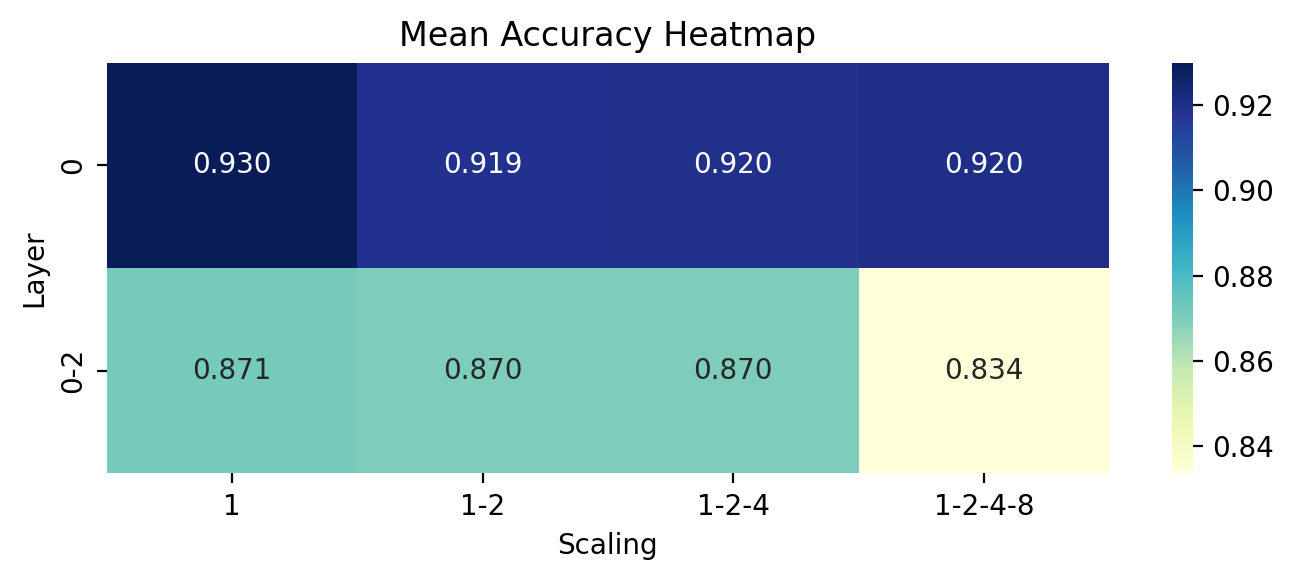

In [20]:
# Create a heatmap with layers and scalings

# Create a pivot table for heatmap
heatmap_df_mean = df.pivot_table(index='layer', columns='scaling', values='accuracy')

# Create heatmap for mean accuracy
plt.figure(figsize=(7, 3), dpi=200)
plt.subplot(1, 1, 1)
sns.heatmap(heatmap_df_mean, annot=True, cmap="YlGnBu", fmt=".3f", cbar=True)
plt.title('Mean Accuracy Heatmap')
plt.xlabel('Scaling')
plt.ylabel('Layer')

plt.tight_layout()
plt.show()